In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Perceptron

In [ ]:
# My Hand Coded Perceptron Model from my Undergrad
from sklearn.base import BaseEstimator, ClassifierMixin

class PerceptronClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, shuffle=True, epochs=10, stop_crit=10, deterministic=False):
        """ 
            Initialize class with chosen hyperparameters.
        Args:
            lr (float): A learning rate / step size.
            shuffle: Whether to shuffle the training data each epoch. DO NOT 
            SHUFFLE for evaluation / debug datasets.
            epochs (int): number of epochs
            stop_crit (int): stopping criteria
            deterministic (bool): whether it's deterministic or not
        """
        self.lr = lr
        self.shuffle = shuffle
        self.epochs = epochs
        self.stop_crit = stop_crit
        self.deterministic = deterministic

    def fit(self, X, y, initial_weights=None):
        """ 
            Fit the data; run the algorithm and adjust the weights to find a 
            good solution
        Args:
            X (array-like): A 2D numpy array with the training data, excluding
            targets
            y (array-like): A 2D numpy array with the training targets
            initial_weights (array-like): allows the user to provide initial 
            weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        # update
        X = self.add_bias(X)
        if initial_weights == None:
            self.weights = self.initialize_weights(len(X[0]))
        else:
            self.weights= initial_weights
        
        # train based on # of epochs if it's deterministic
        if self.deterministic:
            for _ in range(self.epochs):
                self.train(X, y)
        
        # otherwise train until reaching stopping criterion
        else:
            self.stop_training = False
            self.epochs_since_improvement = 0
            self.max_accuracy = 0
            self.best_weights = None
            self.epochs = 0
            self.missclass_rates = []
            while not self.stop_training:
                self.epochs += 1
                self.train(X, y)

            # set weights equal to best weights
            if self.best_weights is not None:
                self.weights = self.best_weights

        return self

    def add_bias(self, X):
        #function to apply bias
        bias_column = np.ones((len(X), 1))
        return np.concatenate([X, bias_column], axis=1)

    def initialize_weights(self, weights_length):
        """ Initialize weights for perceptron. Don't forget the bias!
        Returns:
        """
        return np.zeros(weights_length)    

    def train(self, X, y):
        if self.shuffle:
            X, y = self.shuffle_data(X, y)

        for i in range(len(X)):
            pattern = X[i]
            output = self.get_output(pattern)
            target = y[i]

            # update weights if output != target
            if output != target:
                self.update_weights(pattern, target, output)

        # check stopping criterion
        if not self.deterministic:
            self.check_stop_crit(X, y)

        pass

    def get_output(self, pattern):
        sum = 0
        for i in range(len(pattern)):
            sum += pattern[i] * self.weights[i]

        return 1 if sum > 0 else 0

    def update_weights(self, pattern, target, output):
        for i in range(len(self.weights)):
            weight_change = self.lr * pattern[i]*(target-output)
            self.weights[i] = self.weights[i]+weight_change
    
        pass

    def check_stop_crit(self, X, y):
        accuracy = self._score(X, y)
        self.missclass_rates.append(1-accuracy)

        # no need to keep training
        if accuracy == 1:
            self.stop_training = True

        # update best accuracy and weights
        elif accuracy > self.max_accuracy:
            self.max_accuracy = accuracy
            self.best_weights = copy.copy(self.weights)
            self.epochs_since_improvement = 0

        # stop training if stopping criteria is reached
        else:
            self.epochs_since_improvement += 1
            if self.epochs_since_improvement >= self.stop_crit:
                self.stop_training = True

        pass


    def predict_helper(self, X):
        #helper function for prediction
        y = []
        for i in range(len(X)):
            y.append(self.get_output(X[i]))

        return y


    def predict(self, X):
        """ 
            Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding 
            targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        
        return self.predict_helper(self.add_bias(X))

    def _score(self, X, y):
        predicted = self.predict_helper(X)
        accuracy = 0
        for i in range(len(y)):
            if predicted[i] == y[i]:
                accuracy += 1

        return accuracy / len(y)

    def score(self, X, y):
        """ 
            Return accuracy of model on a given dataset. Must implement own 
            score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predicted = self.predict(X)
        accuracy = 0
        for i in range(len(y)):
            if predicted[i] == y[i]:
                accuracy += 1

        return accuracy / len(y)
    

    def shuffle_data(self, X, y):
        """ 
            Shuffle the data! This _ prefix suggests that this method should 
            only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D 
            array, rather than shuffling X and y exactly the same way, 
            independently.
        """
        split_index = len(X[0])
        data = np.concatenate([X, y], axis=1)
        np.random.shuffle(data)
        data = np.split(data, (split_index,split_index), axis=1)
        return data[0], data[2]
    
    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

#### 1-A: Dataset Preparation

In [18]:
# Load the iris dataset
data = np.loadtxt('iris.txt')
columns = ['C1', 'C2', 'C3', 'C4', 'Label']inst
df = pd.DataFrame(data=data, columns=columns)

# construct dataset A
dfA = df[df['Label'].isin([0,1])].copy()
dfA['Label'] = dfA['Label'].apply(lambda y: 2*y-1)

# construct dataset B
dfB = df[df['Label'].isin([1,2])].copy()
dfB['Label'] = dfB['Label'].apply(lambda y: 2*y-3)

#### 1-B: Dataset Scatterplots

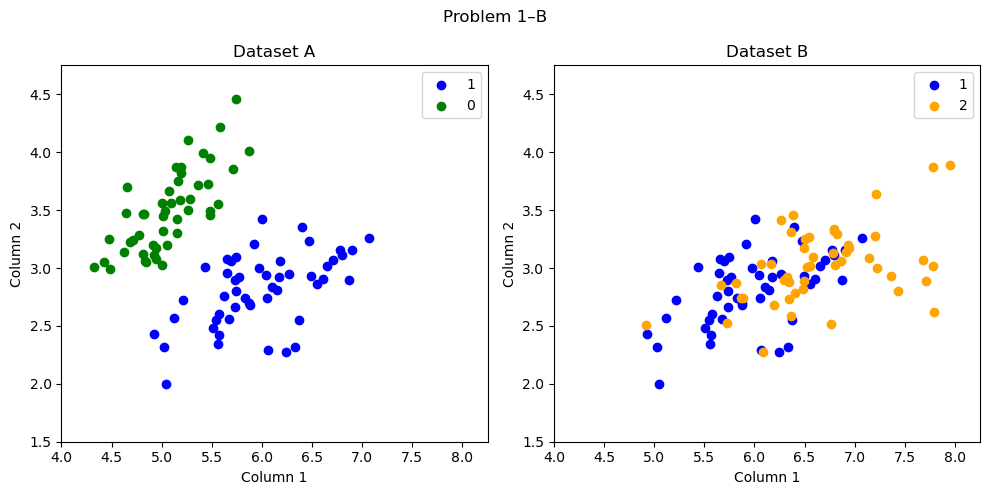

In [33]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot A
ax[0].scatter(dfA[dfA['Label']==1]['C1'], dfA[dfA['Label']==1]['C2'], c='blue', label='1') # plot values labeled 1
ax[0].scatter(dfA[dfA['Label']==-1]['C1'], dfA[dfA['Label']==-1]['C2'], c='green', label='0') # plot values labeled -1
ax[0].set_xlabel('Column 1')
ax[0].set_ylabel('Column 2')
ax[0].legend()
ax[0].set_title('Dataset A')

# plot B
ax[1].scatter(dfB[dfB['Label']==-1]['C1'], dfB[dfB['Label']==-1]['C2'], c='blue', label='1') # plot values labeled -1
ax[1].scatter(dfB[dfB['Label']==1]['C1'], dfB[dfB['Label']==1]['C2'], c='orange', label='2') # plot values labeled 1
ax[1].set_xlabel('Column 1')
ax[1].set_ylabel('Column 2')
ax[1].legend()
ax[1].set_title('Dataset B')

# Set the same axis limits
for a in ax:
    a.set_xlim(4, 8.25)
    a.set_ylim(1.5, 4.75)

plt.suptitle('Problem 1–B')
plt.tight_layout()
plt.show()

#### 1-C: PLA on Dataset A (w/out shuffling)

In [ ]:
# initialize Model & Data
PR = Perceptron()
X = my_arr[:, 0:my_arr.shape[1]-1]
y = my_arr[:, my_arr.shape[1]-1]
y = y.astype(np.int)
X = X.astype(np.int)

PR.fit(X,y)
print(f'scikit perceptron score: {PR.score(X,y)}')

#### 1-D: PLA on Dataset A (w/ shuffling)

#### 1-E: PLA on Dataset B